
<div style="width:30%; margin: auto;">

# Immozila at your service

</div>


<div style="width:60%; margin: auto;">

![house](house.png)  

</div>
<div style="width:10%; margin: auto;">


![app](app.png)  
</div>

# Imports and Loading data

In [22]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from folium import IFrame
from geopy.distance import great_circle
import plotly.express as px
import plotly.graph_objects as go
import semfunction as sf
import numpy as np
# Get the current directory (analyses folder)
current_dir = os.getcwd()

# Navigate up one directory to reach the parent directory (which contains the data folder)
parent_dir = os.path.dirname(current_dir)

# Define the file paths relative to the parent directory using os.path.join
clean_huis_te_koop_path = os.path.join(parent_dir, "data", "cleaned", "clean_house.csv")
clean_apartement_te_koop_path = os.path.join(parent_dir, "data", "cleaned", "clean_app.csv")

house = pd.read_csv(clean_huis_te_koop_path, sep=",")
app = pd.read_csv(clean_apartement_te_koop_path, sep=",")



## Questions to answer

- How many observations and features do you have?
- What is the proportion of missing values per column?
- Which variables would you delete and why?
- What variables are most subject to outliers?
- How many qualitative and quantitative variables are there? How would you transform the qualitative values into numerical values?
- What is the correlation between the variables and the price? Why do you think some variables are more correlated than others?
- How are the variables themselves correlated to each other? Can you find groups of variables that are correlated together?
- How are the number of properties distributed according to their surface?
- Which five variables do you consider the most important and why?
- What are the least/most expensive municipalities in Belgium/Wallonia/Flanders? (in terms of price per m², average price, and median price)

### Q1 How many observations and features do you have?

In [116]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px


# Define function to count non-null values in each column
def count_non_null_values(df):
    return df.notnull().sum()

# Get colors from px.colors.qualitative.swatches()
colors = px.colors.qualitative.swatches()

# Create figure with subplots
fig = make_subplots(rows=2, cols=2, subplot_titles=("Number of Observations - Houses", 
                                                    "Number of Observations - Apartments", 
                                                    "Features and occurrences - Houses", 
                                                    "Features and occurrences - Apartments"))

# Plot 1: Number of observations for house dataset
fig.add_trace(go.Bar(x=['House'], y=[len(house)], marker=dict(color=px.colors.qualitative.Alphabet[13])), row=1, col=1)

# Plot 2: Number of observations for apartment dataset
fig.add_trace(go.Bar(x=['Apartment'], y=[len(app)], marker=dict(color=px.colors.qualitative.Pastel[8])), row=1, col=2)

# Plot 3: Number of non-null values for each feature in house dataset
count_house = count_non_null_values(house)
fig.add_trace(go.Bar(x=count_house.index, y=count_house.values, marker=dict(color=px.colors.qualitative.Alphabet[13])), row=2, col=1)

# Plot 4: Number of non-null values for each feature in apartment dataset
count_apartment = count_non_null_values(app)
fig.add_trace(go.Bar(x=count_apartment.index, y=count_apartment.values, marker=dict(color=px.colors.qualitative.Pastel[8])), row=2, col=2)

# Update layout
fig.update_layout(showlegend=False, title_text="Number of Observations and Features", title_x=0.5)

# Set the same y-axis range for Plot 1 and Plot 2
max_observation_value = max(len(house), len(app))
fig.update_yaxes(range=[0, max_observation_value], row=1, col=1)
fig.update_yaxes(range=[0, max_observation_value], row=1, col=2)
fig.update_yaxes(range=[0, max_observation_value], row=2, col=1)
fig.update_yaxes(range=[0, max_observation_value], row=2, col=2)
fig.update_xaxes(tickangle=45, row=2, col=1)
fig.update_xaxes(tickangle=45, row=2, col=2)


# Show plot
fig.show()

- For the `houses` we have 12397 observations and 25 features
- For the `apartments` we have 9468 observations and 24 features (as surface of good is always empty for apartments)


### Q2 What is the proportion of missing values per column?

In [98]:
def make_bar_perc_plotly(df, colors=None, title="Missing Values Proportion"):
    df_missing = pd.DataFrame()
    df_missing["not-missing"] = df.count()/len(df)*100
    df_missing["missing"] = df.isnull().sum()/len(df)*100

    fig = px.bar(df_missing, x=df_missing.index, y=df_missing.columns, title=title, color_discrete_map=colors)
    fig.show()

house_custom_colors = {"not-missing": px.colors.qualitative.Alphabet[13], "missing": px.colors.qualitative.T10[9]}
make_bar_perc_plotly(house, colors=house_custom_colors, title="Missing Values Proportion - House")

In [99]:
app_custom_colors = {"not-missing": px.colors.qualitative.Pastel[8], "missing": px.colors.qualitative.T10[9]}
make_bar_perc_plotly(app, colors=app_custom_colors, title="Missing Values Proportion - Apartment")

### Q3 Which variables would you delete and why?


| Variable to remove      | Reason |
| ----------- | ----------- |
| surface_of_good | for apartments as surface of good is always empty   |
| property_id | as all records have a unique property_id |
| property_type | as for house this is always house and for apartment this is always apartement |
| terrace | booleans 1/0, we can deduct from terrace surface |
| garden | booleans 1/0, we can deduct from garden surface |

### Q4 What variables are most subject to outliers?


### Q5 How many qualitative and quantitative variables are there? How would you transform the qualitative values into numerical values?


### Q6 What is the correlation between the variables and the price? Why do you think some variables are more correlated than others?

`Anwser`: 

- The price exhibits a significant correlation with the living area and terrace area. (This correlations can be attributed to the logical influence of price on the living space of a house) 
- The price has no correlation with number of facades, surface of goods and number of rooms. 
- The reason price and living area are better correlated is because if the house is bigger the price goes up. 
- It also important to note in which state the house is.


Text(0.5, 1.0, 'correlation in houses')

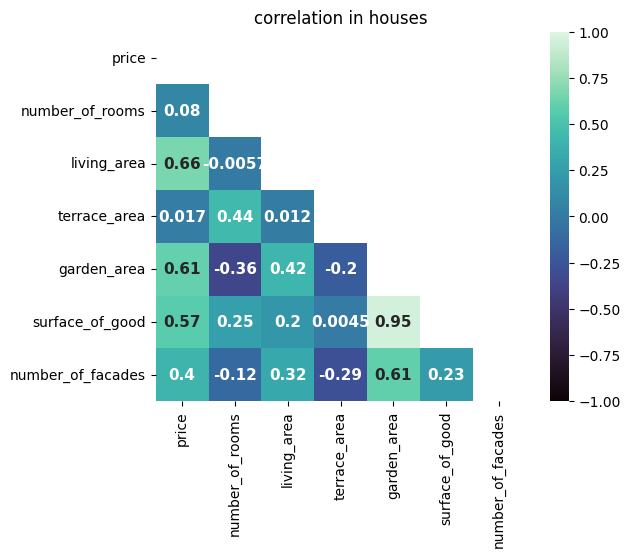

In [27]:
limburg = house[house["province"]=="limburg"]
limburgs = limburg[limburg["state_of_building"]=="GOOD"]
limburgcorr = sf.drop_object_columns(limburgs)
mask = np.triu(np.ones_like(limburgcorr.corr()))
sns.heatmap(limburgcorr.corr(), annot=True, vmin=-1, vmax=1, annot_kws={"fontsize":11, "fontweight":"bold"}, square=True, mask=mask, cmap='mako').set_title("correlation in houses")

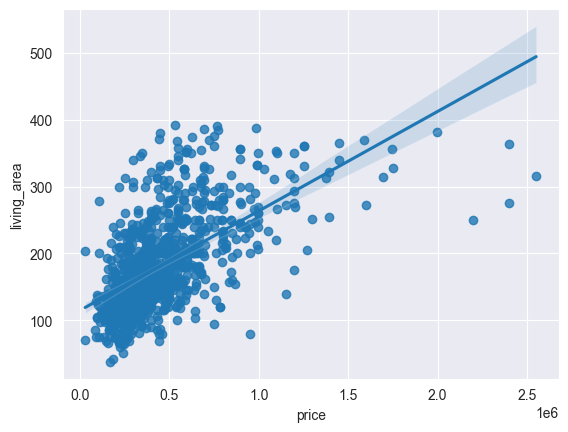

In [101]:
sf.regplot(fdf, "price", "living_area")

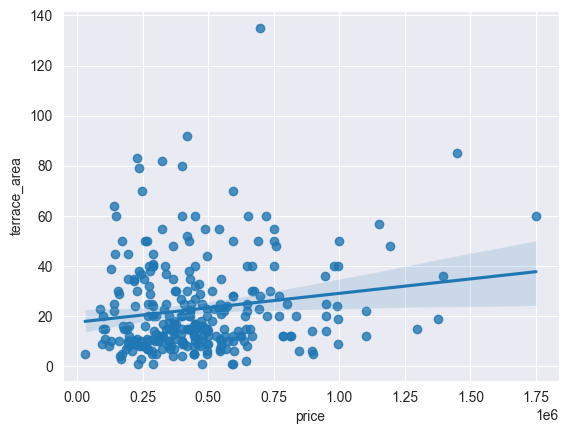

In [102]:
sf.regplot(fdf, "price", "terrace_area")

### Q7 How are the variables themselves correlated to each other? Can you find groups of variables that are correlated together?

`Anwser`: 
- There exist correlations beyond just price, notably in the linear relationships between living area and terrace space and garden area and the overall land size(surface area). 
- As the living area within a house expands, so does the corresponding terrace area. 
- The garden area also expands.


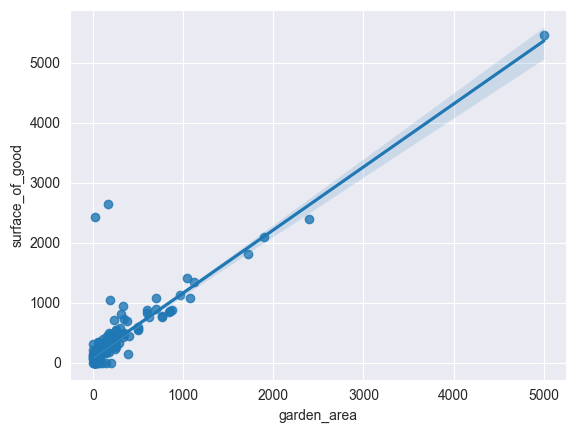

In [103]:
sf.regplot(fdf, "garden_area", "surface_of_good")

### Q8 How are the number of properties distributed according to their surface?


`Anwser`: 
- The distribution of the living area of apartments is right-skewed. 
- This is an expected effect of the standards implemented to the housing in Belgium: 
   - the lower treshold for the apartment area is 18 m² (24 m² for the properties that were built after 2008), 
   - at the same time, there is no upper treshold for the living area, meaning that the extremely large apartments, e.g. penthouses will be present on the market. 
   - The most common size of an apartment for sale is around 100 m².

/tmp/ipykernel_186226/3013769516.py:2: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



Text(0.5, 0, 'Living area, m$^2$')

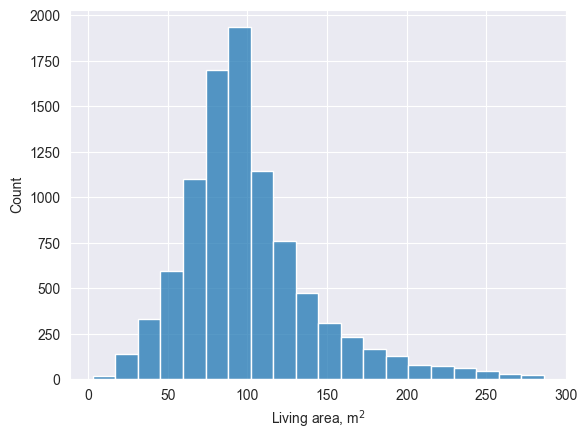

In [104]:
sns.set_style("darkgrid")
sns.histplot(app, x="living_area", bins=20, palette=colors)
plt.xlabel("Living area, m$^2$")


- As for houses, we can observe similar right skew, which is, again, determined by local size regulations for very small houses. 
- Houses are usually larger than apartments: the living area of the majority of house-type properties on the market today reached the size of around 150 m².

Text(0.5, 0, 'Living area, m$^2$')

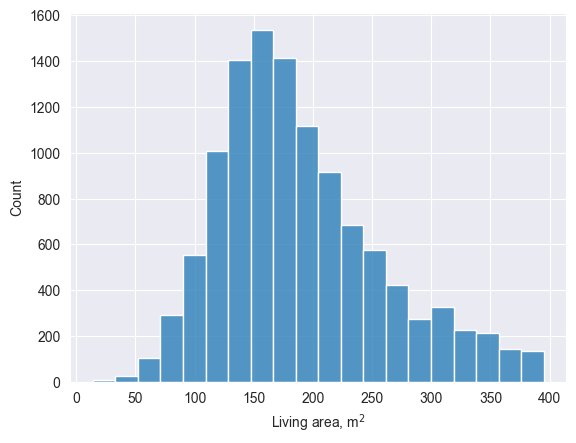

In [105]:
sns.set_style("darkgrid")
sns.histplot(house, x="living_area", bins=20)
plt.xlabel("Living area, m$^2$")

### Q9 Which five variables do you consider the most important and why?

HOUSES
- living area
- surface of goods (only for houses)
- province
- price
- number of facades

APARTMENTS

- living area
- terrace area
- province
- price
- garden area


### Q10 What are the least/most expensive municipalities in Belgium/Wallonia/Flanders? (in terms of price per m², average price, and median price)

`Anwser`: 
- The residences commanding higher market values predominantly gravitate towards prominent urban centers in Belgium. 
- Notably, Brussels, Antwerp, Knokke, and Luik exhibit an elevated average pricing paradigm for residential properties. 
- Conversely, more economical housing options are inclined to be positioned predominantly in the southern regions of Belgium, specifically within the Wallonian territory.

In [106]:
def aggregate_function(df):
    
    grouped = df.groupby('province').agg(
    mean_price=pd.NamedAgg(column='price', aggfunc='mean'),
    median_price=pd.NamedAgg(column='price', aggfunc='median'),
    max_price=pd.NamedAgg(column='price', aggfunc='max'),
    min_price=pd.NamedAgg(column='price', aggfunc='min'),

    mean_price_m2=pd.NamedAgg(column='price_per_m2', aggfunc='mean'),
    median_price_m2=pd.NamedAgg(column='price_per_m2', aggfunc='median'),
    max_price_m2=pd.NamedAgg(column='price_per_m2', aggfunc='max'),
    min_price_m2=pd.NamedAgg(column='price_per_m2', aggfunc='min'),

    lat=pd.NamedAgg(column='latitude', aggfunc='mean'),
    long = pd.NamedAgg(column='longitude', aggfunc='mean')
    

    ).reset_index()
    return grouped
house["price_per_m2"] = house["price"]/house["living_area"]
house_grouped = aggregate_function(house)

In [107]:
def make_map(df):
    # Define a custom marker icon

    map_center  = [df["lat"].mean(), df["long"].mean()]

    # Create the map
    my_map = folium.Map(location=map_center, zoom_start=8)

    for index, row in house_grouped.iterrows():
        Provincie, mean_price, median_price, max_price, min_price, mean_price_m2, median_price_m2, max_price_m2, min_price_m2, lat, long = row
        location_coordinates = [lat, long]
        popup = f"Province: {Provincie}\nMean Price: {round(mean_price,2)} EUR"
        custom_icon = folium.Icon(icon='home', prefix='fa')
        folium.Marker(location_coordinates, 
                    tooltip=popup,
                    icon= custom_icon).add_to(my_map)
        folium.CircleMarker(
            location=location_coordinates,
            radius=mean_price / 100000,  # Adjust the scaling factor as needed
            color='red',
            fill=True,
            fill_color='red'
        ).add_to(my_map)
    # Display the new map
    return my_map


In [108]:
make_map(house_grouped)

In [109]:
def aggregate_locality(df):
    
    grouped = df.groupby(['locality_name','province']).agg(
    mean_price=pd.NamedAgg(column='price', aggfunc='mean'),
    median_price=pd.NamedAgg(column='price', aggfunc='median'),

    mean_price_m2=pd.NamedAgg(column='price_per_m2', aggfunc='mean'),
    median_price_m2=pd.NamedAgg(column='price_per_m2', aggfunc='median'),

    latitude=pd.NamedAgg(column='latitude', aggfunc='mean'),
    longitude =pd.NamedAgg(column='longitude', aggfunc='mean')
    
    ).reset_index()
    return grouped

In [110]:
# grouped_locality = aggregate_locality(house)

# Filtered out the highest price observations
grouped_locality = aggregate_locality(house[house["price"]<= 2000000])

In [111]:
def make_heatmap(df, column,radius=2,key="all"):
    
    customdata=df[['locality_name', column,'province']]
    hover_template=('<b>Locality:</b> %{customdata[0]}<br>'
                '<b>Province:</b> %{customdata[2]}<br>'
                '<b>Price:</b> €%{customdata[1]:,.0f}<br>')
    fig = go.Figure(go.Densitymapbox(
        lat=df['latitude'],
        lon=df['longitude'],
        z=df[column],
        customdata=customdata,
        hovertemplate=hover_template,
        radius=radius,

    ))

    fig.update_layout(
        mapbox=dict(
            style="open-street-map",
            center=dict(lat=df['latitude'].mean(), lon=df['longitude'].mean()),
            zoom=6,
        ),
    )

    # Show the plot
    fig.show()

### Heatmap showing distribution of Average Price per Municipality

In [112]:
make_heatmap(grouped_locality, "mean_price",radius=10)

### Heatmap showing distribution of Median Price per Municipality

In [113]:
make_heatmap(grouped_locality, "median_price",radius=10)

### Heatmap showing distribution of Average Price per m2 per Municipality

In [114]:
make_heatmap(grouped_locality, "mean_price_m2",radius=10)